In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from _src.kf import KalmanFilter
from _src.viz import plot_ellipse
from jax import random

In [8]:
def plot_uncertainty_ellipses(means, covs):
    timesteps = len(means)
    for t in range(timesteps):
        plot_ellipse(covs[t], means[t], ax, plot_center=False, alpha=0.7)


In [5]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

dx = 1.1
timesteps = 20
key = random.PRNGKey(27182)

mean_0 = jnp.array([1, 1, 1, 0]).astype(float)
Sigma_0 = jnp.eye(4)
A = jnp.array([
    [0.1, 1.1, dx, 0],
    [-1, 1, 0, dx],
    [0, 0, 0.1, 0],
    [0, 0, 0, 0.1]
])
C = jnp.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])
Q = jnp.eye(4) * 0.001
R = jnp.eye(2) * 4

lds_instance = KalmanFilter(A, C, Q, R, mean_0, Sigma_0, timesteps)
state_hist, obs_hist = lds_instance.sample(key)

res = lds_instance.filter(obs_hist)
mean_hist, Sigma_hist, mean_cond_hist, Sigma_cond_hist = res
mean_hist_smooth, Sigma_hist_smooth = lds_instance.smooth(mean_hist, Sigma_hist, mean_cond_hist,
                                                                Sigma_cond_hist)


### Draw Samples

In [5]:
%%time
result = sample_filter_smooth(lds_instance, key)

CPU times: user 4.86 s, sys: 453 ms, total: 5.31 s
Wall time: 4.99 s


In [6]:
l2_filter = jnp.linalg.norm(result["z_hist"][:, :2] - result["mu_hist"][:, :2], 2)
l2_smooth = jnp.linalg.norm(result["z_hist"][:, :2] - result["mu_hist_smooth"][:, :2], 2)

print(f"L2-filter: {l2_filter:0.4f}")
print(f"L2-smooth: {l2_smooth:0.4f}")

L2-filter: 3.2481
L2-smooth: 2.0450


#### Viz

Text(0.5, 1.0, 'State space')

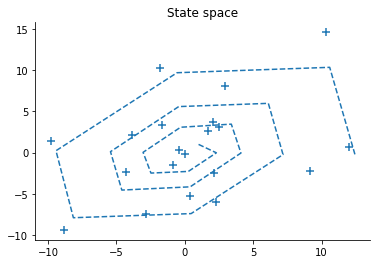

In [6]:
fig, ax = plt.subplots()
ax.plot(*state_hist[:, :2].T, linestyle="--")
ax.scatter(*obs_hist.T, marker="+", s=60)
ax.set_title("State space")

Text(0.5, 1.0, 'Filtered')

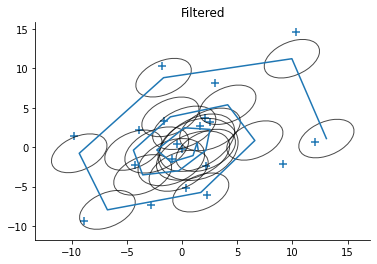

In [9]:
fig, ax = plt.subplots()
ax.plot(*mean_hist[:, :2].T)
ax.scatter(*obs_hist.T, marker="+", s=60)
plot_uncertainty_ellipses(mean_hist[:, :2], Sigma_hist[:, :2, :2])
ax.set_title("Filtered")

Text(0.5, 1.0, 'Smoothed')

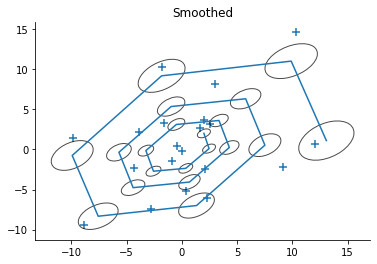

In [10]:
fig, ax = plt.subplots()
ax.plot(*mean_hist_smooth[:, :2].T)
ax.scatter(*obs_hist.T, marker="+", s=60)
plot_uncertainty_ellipses(mean_hist_smooth[:, :2], Sigma_hist_smooth[:, :2, :2])
ax.set_title("Smoothed")